# Churn analysis

In [13]:
%config IPCompleter.greedy=True

In [16]:
# This is a a test docer persist

In [9]:
#
# Import modules
#
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Lambda,
    RepeatVector,
    Permute,
    Flatten,
    Activation,
    Multiply,
)
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.models import Sequential, Model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_curve,
    recall_score,
    plot_roc_curve,
)
import warnings

warnings.filterwarnings("ignore")


pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

## Import data

In [8]:
#
# Import data
#
data_path = "tensor-house-data/promotions/churn-media-data/"
users = pd.read_csv(
    data_path + "users.csv.zip",
    compression="zip",
    index_col="uid",
    parse_dates=["registration_date"],
)
logs = pd.read_csv(
    data_path + "usage_logs.csv.zip",
    compression="zip",
    index_col="uid",
    parse_dates=["date"],
)

# EDA

### Check missing data

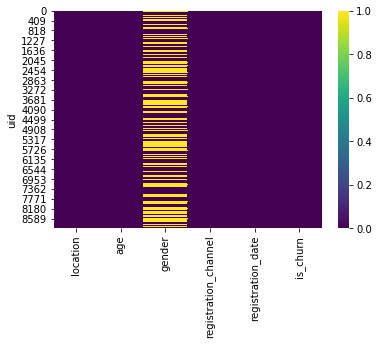

In [4]:
sns.heatmap(users.isna(),cmap ='viridis')

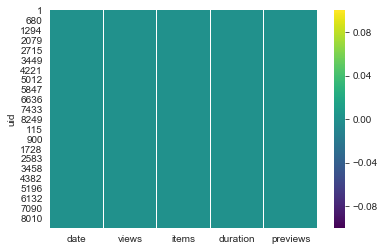

In [179]:
sns.heatmap(logs.isna(),cmap ='viridis')

Nous remarquons beaucoup de missing data dans la colonne Gender, nous pouvons remédier à cela dans le pipeline training.

Aucune data missing dans les logs ( normal)

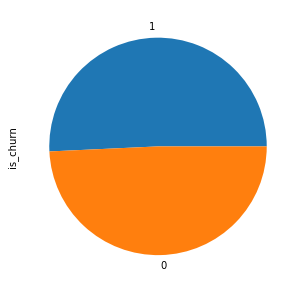

In [5]:
# We have a balanced dataset 

is_churn = users['is_churn'].value_counts()/len(users.is_churn)

plot = is_churn.plot.pie( figsize=(5, 5))

In [6]:
users.columns

Index(['location', 'age', 'gender', 'registration_channel', 'registration_date', 'is_churn'], dtype='object')

In [192]:
#  valeurs abbérantes pour le
users.age.describe()

count    8979.000000
mean       15.051231
std        18.008910
min       -43.000000
25%         0.000000
50%        18.000000
75%        27.000000
max       810.000000
Name: age, dtype: float64

In [216]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8979 entries, 0 to 8978
Data columns (total 6 columns):
location                8979 non-null int64
age                     8979 non-null int64
gender                  4681 non-null object
registration_channel    8979 non-null int64
registration_date       8979 non-null datetime64[ns]
is_churn                8979 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 811.0+ KB


In [319]:
users_age = users[users['age'].between(0,90)]

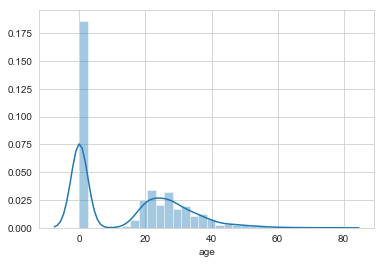

In [320]:
sns.distplot(users_age.age)

In [321]:
print(
    "{:.2%}% of users put 0 as age, they probably didn't want to give their age, we will transform age value to 0 for abberrant values".format(
        sum(users.age == 0) / len(users.age)
    )
)

47.72%% of users put 0 as age, they probably didn't want to give their age, we will transform age value to 0 for abberrant values


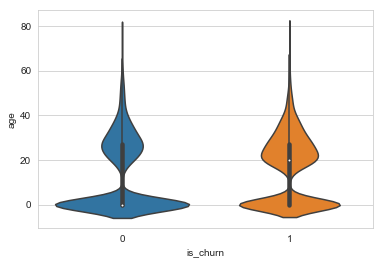

In [322]:
users['age']=  users['age'].apply(lambda x: 0 if(x<0 or x>90) else x)

sns.violinplot(x='is_churn',y='age',data=users)

> No difference

Text(0, 0.5, 'Count')

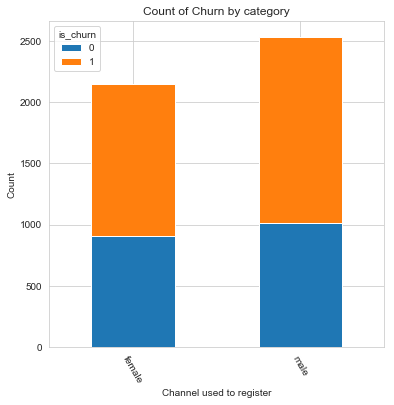

In [281]:
# Count of  churned user by gender
# The na values are automatically
data_req = users.groupby(["gender", "is_churn"]).size().unstack(level=1)
data_req.plot(kind="bar", stacked=True, figsize=(6, 6))
plt.title("Count of Churn by category")
plt.xlabel("Channel used to register", fontsize=10)
plt.xticks(rotation=300)
plt.ylabel("Count", fontsize=10)

> No visible difference  by gender 

Text(0, 0.5, 'Count')

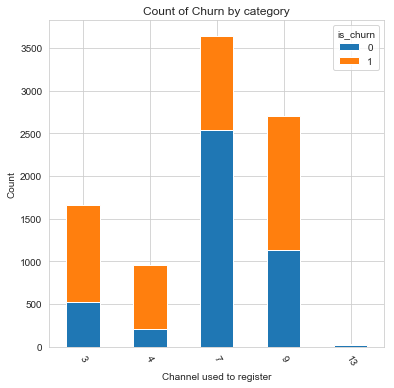

In [277]:
# is churn by registration_channel

data_req = users.groupby(['registration_channel', 'is_churn']).size().unstack(level=1)
data_req.plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Count of Churn by category')
plt.xlabel('Channel used to register', fontsize=10)
plt.xticks(rotation=300)
plt.ylabel('Count', fontsize=10)

> Notable différence between the churned  categories

Text(0, 0.5, 'Count')

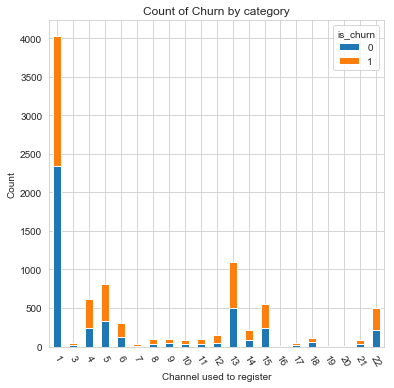

In [345]:
# is churn by registration_channel

data_req = users.groupby(['location', 'is_churn']).size().unstack(level=1)
data_req.plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Count of Churn by category')
plt.xlabel('Channel used to register', fontsize=10)
plt.xticks(rotation=300)
plt.ylabel('Count', fontsize=10)

# Modeling with feature engineering

In [8]:
print(
    f"Nous avons {np.abs(len(set(logs.index))-len(set(users.index)))} users de différence entre les dataset logs et le dataset user"
)

Nous avons 76 users de différence entre les dataset logs et le dataset user


In [9]:
agg_logs = logs.drop(columns="date").groupby("uid").agg("sum")
agg_logs.head()

,views,items,duration,previews
uid,,,,
0,2634,6640,883533.0,4544
1,22987,24674,6465043.0,7135
2,52439,36158,13512932.0,4897
3,5337,6734,1481273.0,2000
4,20663,18346,5194508.0,7196


In [10]:
# Feature engineering
users['days_registered'] = (pd.Timestamp.now()-users['registration_date']).dt.days
users.drop(columns=['registration_date'],inplace =True)

In [11]:
result = users.join(agg_logs, on='uid')
result.head()

,location,age,gender,registration_channel,is_churn,days_registered,views,items,duration,previews
uid,,,,,,,,,,
0,15,17,female,3,1,2285,2634.0,6640.0,883533.0,4544.0
1,13,40,female,9,0,5355,22987.0,24674.0,6465043.0,7135.0
2,14,23,male,9,1,5052,52439.0,36158.0,13512932.0,4897.0
3,1,19,female,3,1,2273,5337.0,6734.0,1481273.0,2000.0
4,1,0,NaN,9,1,2267,20663.0,18346.0,5194508.0,7196.0


In [12]:
result.shape

(8979, 10)

In [13]:
categorical_features = list(
    result.dtypes.where(result.dtypes == object).dropna().index
) + ["registration_channel"]

numeric_features = list(result.dtypes.where(result.dtypes != object).dropna().index)
numeric_features.remove("registration_channel")
numeric_features.remove("is_churn")

features = categorical_features + numeric_features
X = result[features]
y = result["is_churn"]

In [14]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0))]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preproc = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [15]:
print('Training on X  shape : ',X.shape)
print('Training on y  shape : ',y.shape)

Training on X  shape :  (8979, 9)
Training on y  shape :  (8979,)


In [16]:
X_t = preproc.fit_transform(X)
print('Training on X  shape : ',X_t.shape)
print('Training on y  shape : ',y.shape)

Training on X  shape :  (8979, 15)
Training on y  shape :  (8979,)


## Clustering

Text(0.5, 1.0, 'Truncated SVD of representation dataset')

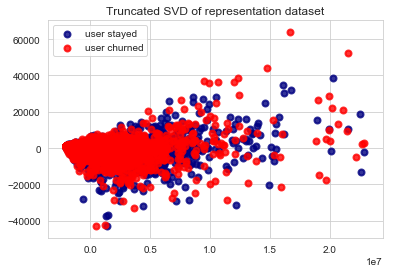

In [365]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

X_r = PCA(n_components=2).fit_transform(X_t)

colors = ["navy", "red"]
lw = 2
target_names = ["user stayed", "user churned"]
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
    plt.savefig("TruncatedSVD.png")

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("Truncated SVD of representation dataset")

> No clear clusters at least in 2D

## Model spot checking

### Defining metric 

In our problem we want to detect user suceptible to churn to remedie the problem. 

We need to detect users before they leave , so we need to maximize the recall.  

In [400]:
ml_models = [
    ("dummy_stratified", DummyClassifier(strategy="stratified")),
    ("logistic_reg", LogisticRegression(n_jobs=-1)),
    ("decision_tree", DecisionTreeClassifier(criterion="gini")),
    ("random_forest", RandomForestClassifier(n_jobs=-1)),
]

model_score = {}

for name, model in ml_models:
    scores = cross_val_score(model, X_t, y, scoring="recall", cv=10, n_jobs=-1)
    model_score[name] = {
        "score": scores,
        "mean_score": np.mean(scores),
        "std_score": np.std(scores),
    }

Text(0, 0.5, 'Recall score')

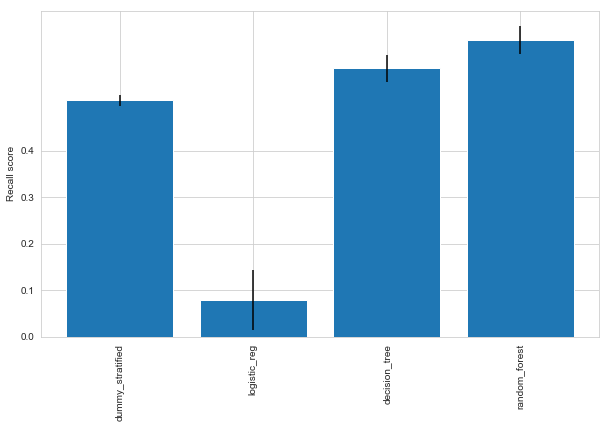

In [403]:
model_results = pd.DataFrame(model_score)

ind = np.arange(model_results.loc["mean_score"].shape[0])
plt.figure(figsize=(10, 6))

plt.bar(
    ind,
    height=model_results.loc["mean_score"].values,
    yerr=model_results.loc["std_score"],
)
plt.xticks(ind, list(res.columns), rotation="vertical")
plt.yticks(np.arange(0, 0.5, 0.1))
plt.ylabel("F0.2 Score")

> Random Forest captures  best the complexity of the model 

### Hyperparameter tuning

In [440]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2)

Now that we have chosen our best performing machine learning algorithms, let's combine the methods and tune the parameters

````python
params =  {'random_forest__n_estimators': [500,800,900]}

params = {'random_forest__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'random_forest__max_features': ['auto', 'sqrt'],
 'random_forest__min_samples_leaf': [1, 2, 4],
 'random_forest__min_samples_split': [2, 5, 10],
 'random_forest__n_estimators': [200, 400, 600, 1000, 1200, 1400, 1600, 1800, 2000]}


pipe = Pipeline(steps=[('preprocessor', preproc), ("random_forest", RandomForestClassifier(n_jobs=-1))])
clf = GridSearchCV(pipe, params, cv=3,scoring='recall',n_jobs=-1)
clf.fit(X_train, y_train)

````


In [ ]:
params = {"n_estimators": [500, 800, 900]}

clf = GridSearchCV(RandomForestClassifier(), params, cv=3, scoring="recall")
clf.fit(X_train, y_train)

print("Results for Random Forest")
print(clf.best_score_)

print(clf.best_params_)

### Analyzing results

# TODO explain this  
* ROC curve 
* Confusion Matrix

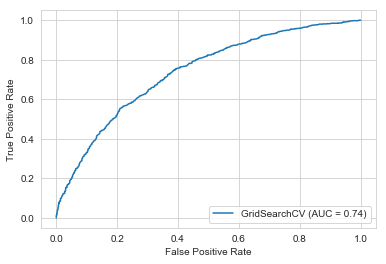

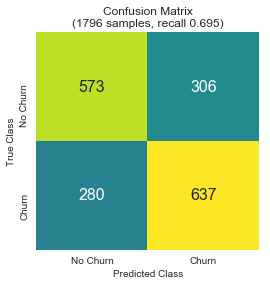

In [561]:
y_pred = clf.predict(X_test)

plot_roc_curve(clf, X_test, y_test)

plot_confusion_matrix(y_test, y_pred, ["No Churn", "Churn"])

In [10]:
feature_names

NameError: name 'feature_names' is not defined

In [606]:
X_t[0]

array([1.50000e+01, 1.70000e+01, 2.27400e+03, 2.63400e+03, 6.64000e+03,
       8.83533e+05, 4.54400e+03, 0.00000e+00, 1.00000e+00, 0.00000e+00,
       1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00])

In [ ]:
ohe = preproc.named_transformers_["cat"].named_steps["onehot"]

feature_names = ohe.get_feature_names(input_features=categorical_features)

feature_names = np.r_[numeric_features, feature_names]

importances = clf.best_estimator_.feature_importances_

sorted_idx = importances.argsort()

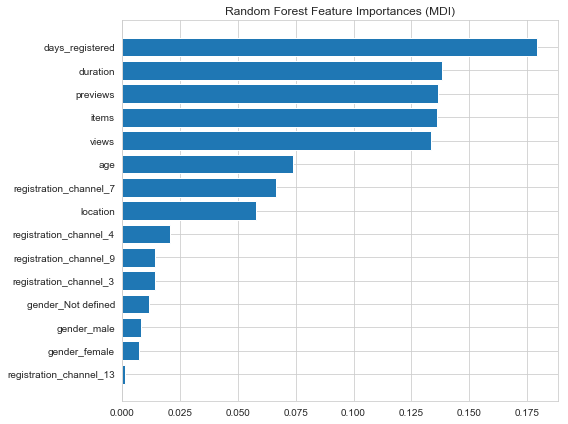

In [611]:
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(y_ticks, importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [594]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    clf, X_test, y_test, n_repeats=10, scoring="recall", n_jobs=-1
)

In [619]:
# TODO explain this

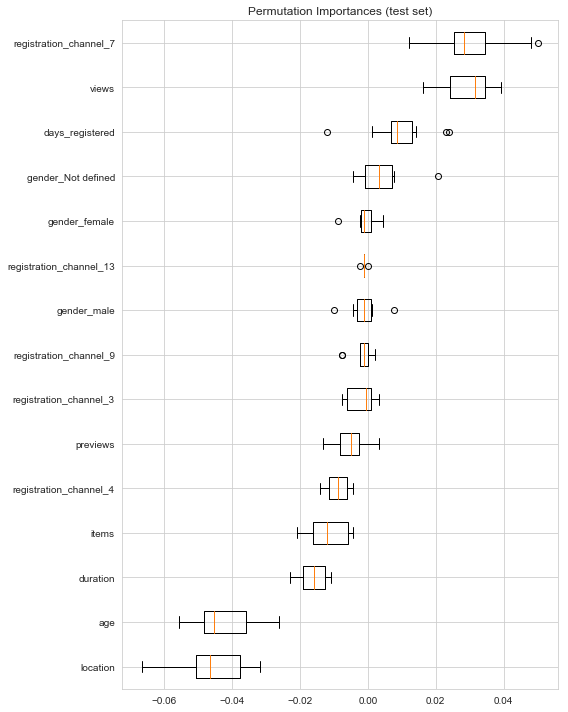

In [601]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8, 10))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=feature_names[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# LSTM model

The second step is to build an LSTM model using Keras. We use a model with two inputs:
* One input is a 3D tensor that consist of ordered usage histories aggregated by weeks. This is input is processed by LSTM.
* The second input is the user profile. This input is proceed by a dense layer.

Output of the two submodels are concatenated and processed by several dense layers.

In [23]:
pd.DataFrame(X_t,columns=feature_names).head()

,location,age,days_registered,views,items,duration,previews,gender_Not defined,gender_female,gender_male,registration_channel_3,registration_channel_4,registration_channel_7,registration_channel_9,registration_channel_13
0,15.0,17.0,2285.0,2634.0,6640.0,883533.0,4544.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,13.0,40.0,5355.0,22987.0,24674.0,6465043.0,7135.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,14.0,23.0,5052.0,52439.0,36158.0,13512932.0,4897.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,19.0,2273.0,5337.0,6734.0,1481273.0,2000.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,2267.0,20663.0,18346.0,5194508.0,7196.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
X.head()

,gender,registration_channel,location,age,days_registered,views,items,duration,previews
uid,,,,,,,,,
0,female,3,15,17,2285,2634.0,6640.0,883533.0,4544.0
1,female,9,13,40,5355,22987.0,24674.0,6465043.0,7135.0
2,male,9,14,23,5052,52439.0,36158.0,13512932.0,4897.0
3,female,3,1,19,2273,5337.0,6734.0,1481273.0,2000.0
4,NaN,9,1,0,2267,20663.0,18346.0,5194508.0,7196.0


In [ ]:
#
X, y = (
    profiles[
        [
            "location",
            "age",
            "registration_channel",
            "registred_days",
            "gender_female",
            "gender_male",
        ]
    ],
    profiles["is_churn"],
)
x = pd.get_dummies(x, columns=["registration_channel"])